# SARIMA

We will explain this model by building up letter by letter.  SARIMA(p,d,q)(P,D,Q,s)
 , Seasonal Autoregression Moving Average model:

AR(p)
  - autoregression model i.e. regression of the time series onto itself. The basic assumption is that the current series values depend on its previous values with some lag (or several lags). The maximum lag in the model is referred to as  p
 . To determine the initial  p
 , you need to look at the PACF plot and find the biggest significant lag after which most other lags become insignificant.
 
MA(q)
  - moving average model. Without going into too much detail, this models the error of the time series, again with the assumption that the current error depends on the previous with some lag, which is referred to as  q
 . The initial value can be found on the ACF plot with the same logic as before.
Let's combine our first 4 letters:

$AR(p)+MA(q)=ARMA(p,q)$
 

What we have here is the Autoregressive–moving-average model! If the series is stationary, it can be approximated with these 4 letters. Let's continue.

I(d)
  - order of integration. This is simply the number of nonseasonal differences needed to make the series stationary. In our case, it's just 1 because we used first differences.
Adding this letter to the four gives us the  ARIMA
  model which can handle non-stationary data with the help of nonseasonal differences. Great, one more letter to go!

S(s)
  - this is responsible for seasonality and equals the season period length of the series
With this, we have three parameters:  (P,D,Q)
 

P
  - order of autoregression for the seasonal component of the model, which can be derived from PACF. But you need to look at the number of significant lags, which are the multiples of the season period length. For example, if the period equals 24 and we see the 24-th and 48-th lags are significant in the PACF, that means the initial  P
 should be 2.

Q
  - similar logic using the ACF plot instead.

D
  - order of seasonal integration. This can be equal to 1 or 0, depending on whether seasonal differeces were applied or not.

In [96]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error

In [97]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [98]:
data=pd.read_csv('EnergyProduction.csv')

In [99]:
data['DATE']=pd.to_datetime(data['DATE'])
data.set_index('DATE',inplace=True)
data

,EnergyIndex
DATE,
1970-01-01,43.0869
1970-02-01,42.5577
1970-03-01,41.6215
1970-04-01,40.1982
1970-05-01,39.9321
...,...
1989-08-01,75.2704
1989-09-01,69.5107
1989-10-01,66.0620


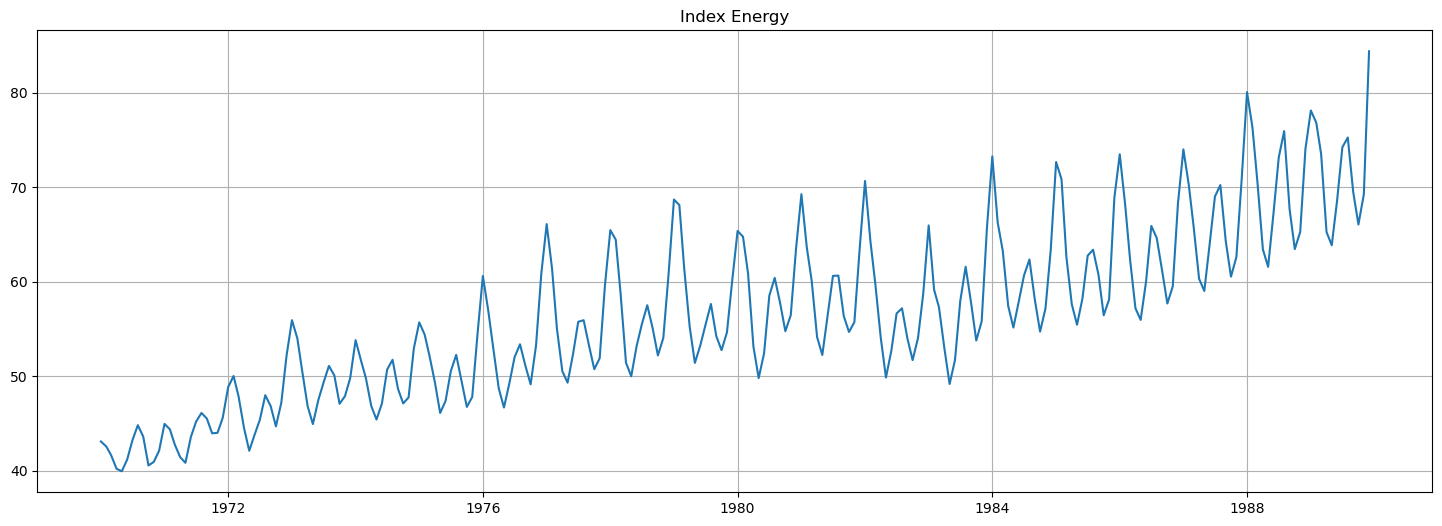

In [100]:
plt.figure(figsize=(18, 6))
plt.plot(data)
plt.title('Index Energy')
plt.grid(True)
plt.show()

## Plot time series data

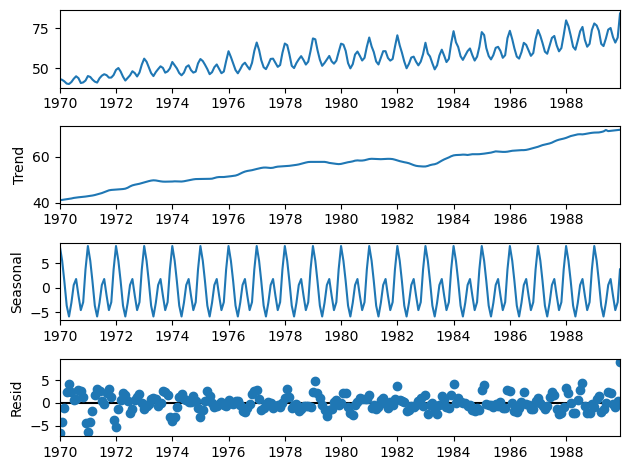

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

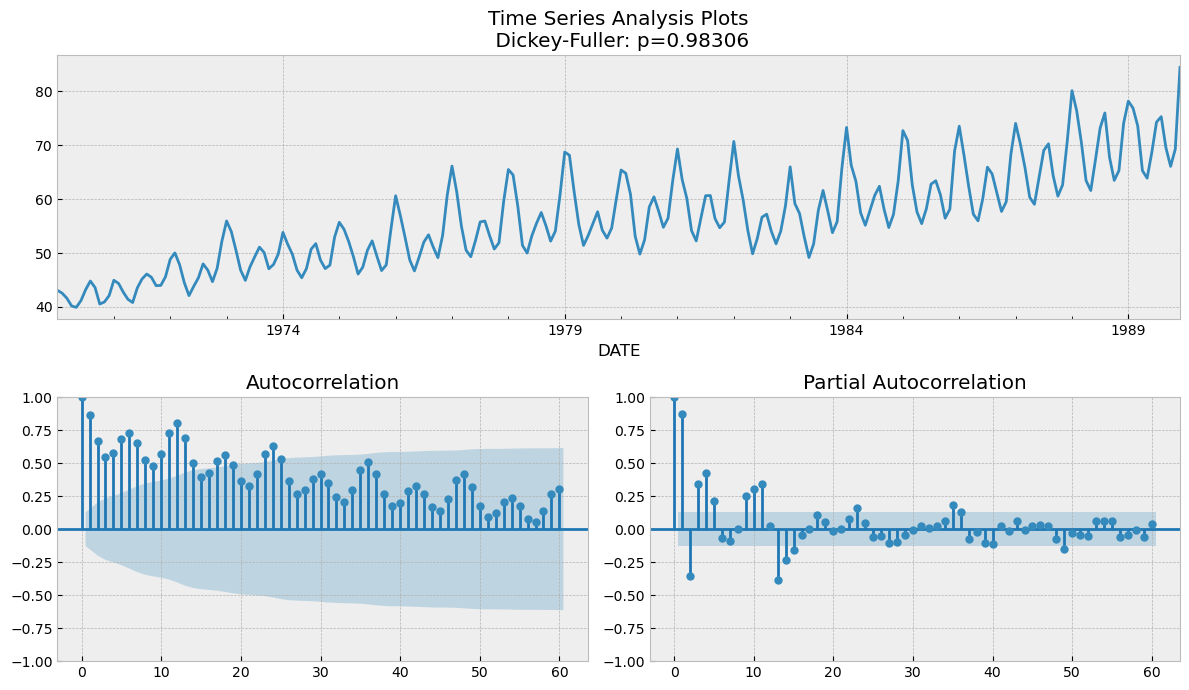

In [102]:
tsplot(data.EnergyIndex, lags=60)

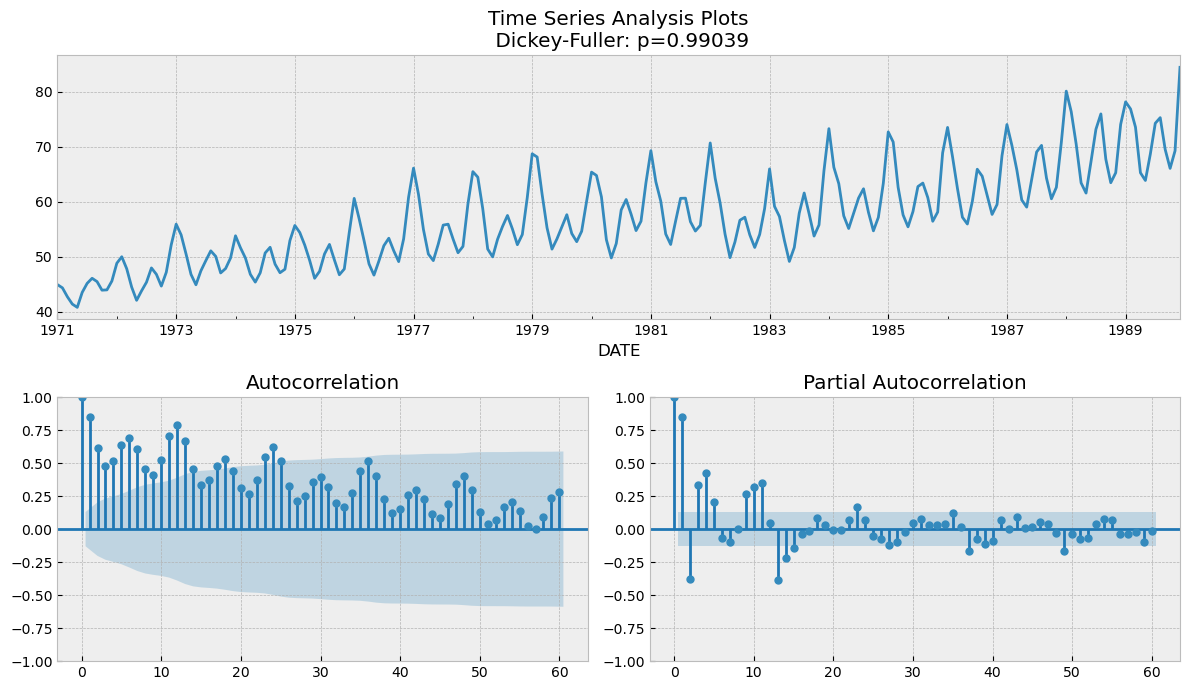

In [103]:
# The seasonal difference
index_dift= data.EnergyIndex - data.EnergyIndex.shift(12)
tsplot(data.EnergyIndex[12:], lags=60)

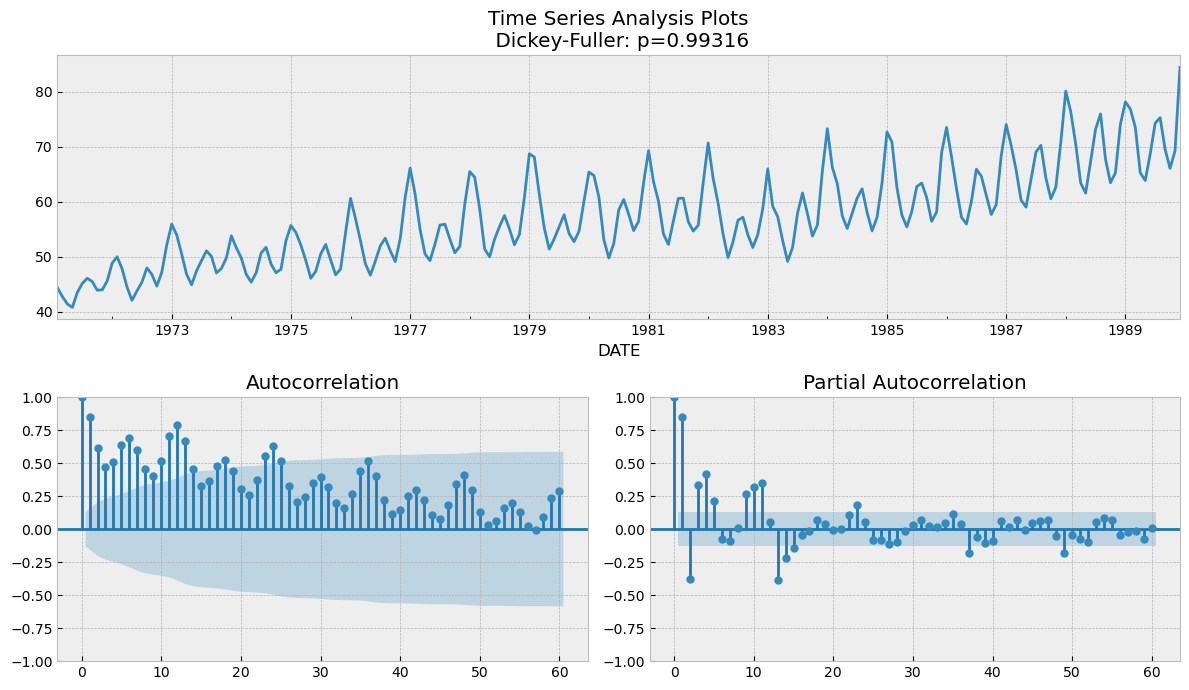

In [104]:
Index_dift = index_dift - index_dift.shift(1)
tsplot(data.EnergyIndex[12+1:], lags=60)

sangat di sayangkan tidak ada perubahan yang berarti dengan penambahan time lag 1.

## SARIMA parameters

- **p**
  kemungkinan adalah 14 atau 25 karena lag signifikan terakhir pada **PACF**, setelah itu tidak terlalu signifikan.
- d
  sama dengan 1 karena kita membutuhkan transform menjadi stationary.
- **q**
  kemungkinan berada pada angka 17 **ACF**
- P
  kemungkinan 2, karena pada  **PACF** data 12 dan 24 tidak menunjukan angka yang cukup segnifikan
- D
  sama dengan 1 karena kita membutuhkan transform menjadi stationary.
- Q
  kemungkinan 2, kerena pada **ACF** data 12,24 menunjukan angka yang cukup segnifikan

In [105]:
# setting initial values and some bounds for them
ps = {13,14,38,50}
d=1 
qs = range(24,27)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 12 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [106]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [107]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(data.EnergyIndex, parameters_list, d, D, s)

  0%|          | 0/72 [00:00<?, ?it/s]

CPU times: total: 1h 6min 54s
Wall time: 11min 13s


In [108]:
result_table.head()

,parameters,aic
0,"(14, 24, 0, 0)",866.901551
1,"(14, 25, 0, 0)",868.710599
2,"(13, 24, 0, 0)",869.449973
3,"(14, 26, 0, 0)",873.481290
4,"(13, 26, 0, 0)",873.708096


In [109]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data.EnergyIndex, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                           EnergyIndex   No. Observations:                  240
Model:             SARIMAX(14, 1, 24)x(0, 1, [], 12)   Log Likelihood                -394.451
Date:                               Wed, 07 Dec 2022   AIC                            866.902
Time:                                       14:31:15   BIC                           1000.475
Sample:                                   01-01-1970   HQIC                           920.800
                                        - 12-01-1989                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2368      0.712      0.333      0.739      -1.158       1.632
ar.L2      

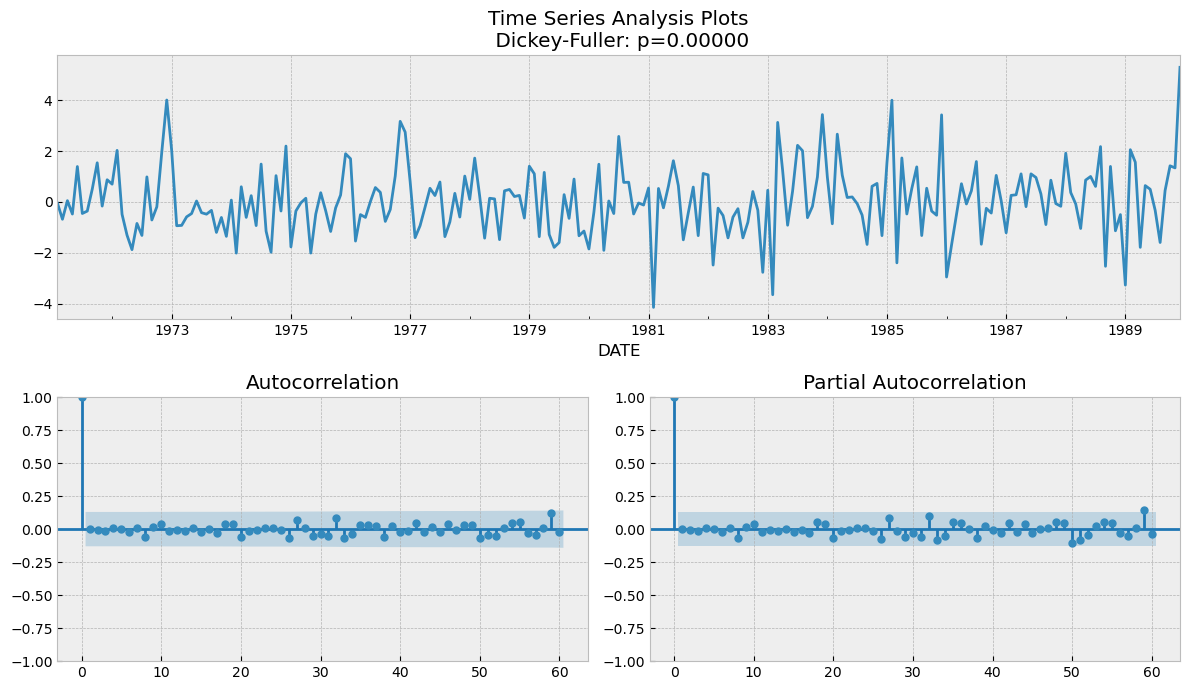

In [110]:
tsplot(best_model.resid[12+1:], lags=60)

In [111]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    mape = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])
    rmse = mean_squared_error(data['actual'][s+d:], data['sarima_model'][s+d:])
    mae = mean_absolute_error(data['actual'][s+d:], data['sarima_model'][s+d:])
    print(f'MAPE:{mape}')
    print(f'RMSE:{rmse}')
    print(f'MAE:{mae}')
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(mape))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)



MAPE:1.7790918762514853
RMSE:1.844518794972713
MAE:1.0346672425655064


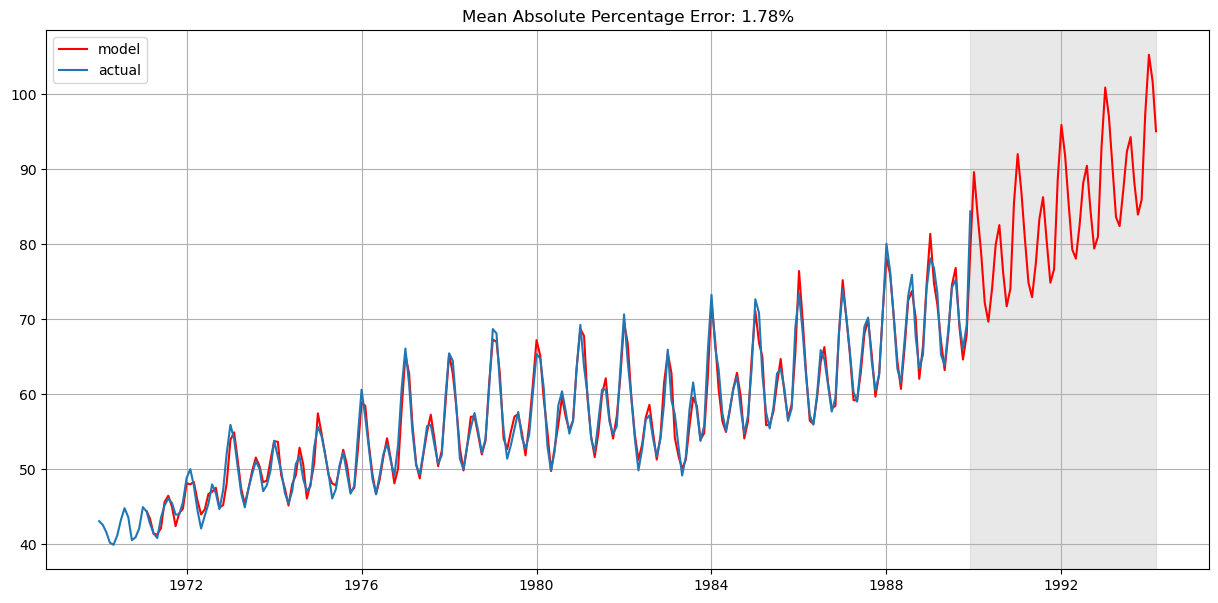

In [112]:
plotSARIMA(data, best_model, 50)

# Deeplearning CNN with LSTM layer

In [64]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from array import array 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1970-01-01 to 1989-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EnergyIndex  240 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


<AxesSubplot:xlabel='DATE'>

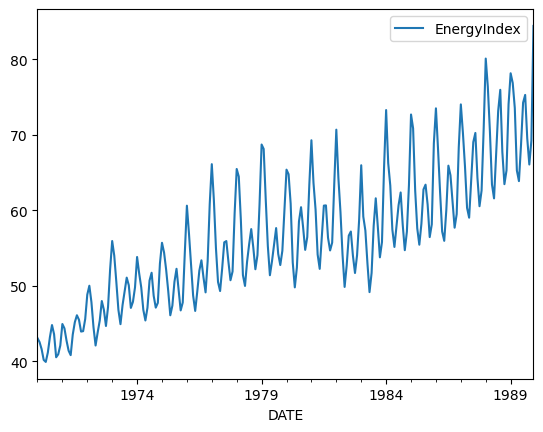

In [66]:
data.plot()

In [67]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Function to make windowing data set from an array
    window_size: range between X and y data (int) 
    batch_size: size of batch (int)
    shuffle_buffer: the number of elements from this dataset from which the new dataset will sample (int)     
    """
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))

    return ds.batch(batch_size).prefetch(1)

In [68]:
# Convert data to numpy array
dataset= data.values
dataset
# Get the number of rows to train the model on (80% train|20% val)
training_data_len= math.ceil(len(dataset)*.8)
training_data_len

192

In [69]:
#split data set
train = data[:training_data_len]
valid = data[training_data_len-60:]

#scalling val and train data
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train)
val= scaler.transform(valid)

# windowing dataset
window_size=60
batch_size=100
shuffle_buffer=1000
train=windowed_dataset(train, window_size, batch_size, shuffle_buffer)
val=windowed_dataset(val, window_size, batch_size, shuffle_buffer)

In [70]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(100, return_sequences = True, input_shape = (window_size, 1)))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(100, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [71]:
#set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-02)
#set callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min', patience=30,
                                                  restore_best_weights=True)
#Compile model
model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=["mae"],)
#fit model
hist=model.fit(train, epochs = 50, batch_size = 32,validation_data=val, callbacks=[early_stopping])

Epoch 1/50
2/2 [==============================] - 6s 1s/step - loss: 0.8745 - mae: 0.8745 - val_loss: 0.9086 - val_mae: 0.9086
Epoch 2/50
2/2 [==============================] - 0s 120ms/step - loss: 0.5361 - mae: 0.5361 - val_loss: 0.4718 - val_mae: 0.4718
Epoch 3/50
2/2 [==============================] - 0s 119ms/step - loss: 0.2109 - mae: 0.2109 - val_loss: 0.1510 - val_mae: 0.1510
Epoch 4/50
2/2 [==============================] - 0s 117ms/step - loss: 0.1981 - mae: 0.1981 - val_loss: 0.3798 - val_mae: 0.3798
Epoch 5/50
2/2 [==============================] - 0s 120ms/step - loss: 0.1664 - mae: 0.1664 - val_loss: 0.3935 - val_mae: 0.3935
Epoch 6/50
2/2 [==============================] - 0s 119ms/step - loss: 0.1599 - mae: 0.1599 - val_loss: 0.2558 - val_mae: 0.2558
Epoch 7/50
2/2 [==============================] - 0s 118ms/step - loss: 0.1353 - mae: 0.1353 - val_loss: 0.1941 - val_mae: 0.1941
Epoch 8/50
2/2 [==============================] - 0s 118ms/step - loss: 0.1518 - mae: 0.1518 

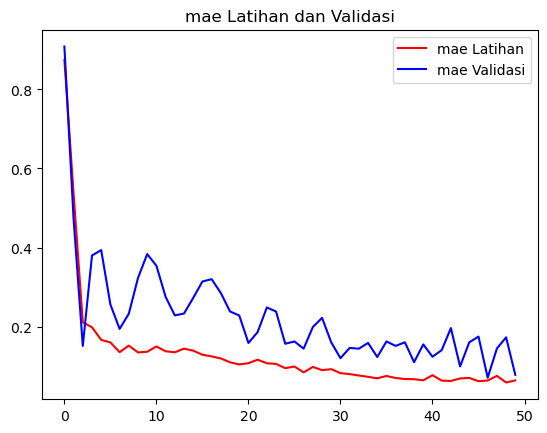

<Figure size 640x480 with 0 Axes>

In [72]:
acc = hist.history['mae']
val_acc = hist.history['val_mae']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='mae Latihan')
plt.plot(epochs, val_acc, 'b', label='mae Validasi')
plt.title('mae Latihan dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

In [73]:
# scalling validation data
scale_valid=scaler.transform(valid)

#Create the testing data set
X_test = []
y_test = scale_valid[60:]
for i in range(60,len(scale_valid)):
    X_test.append((scale_valid[i-60:i, 0]))

In [74]:
# reshape data
X_test= np.array(X_test)
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1 ))

In [75]:
#predict and inverse scalling
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 17ms/step


In [76]:
# split train and valid data for visualization
train= data[:training_data_len]
valid_df= data[training_data_len:]
valid_df['Predictions']= predictions

MAPE:3.667495539086408
RMSE:13.60631431350251
MAE:2.5979473889668783


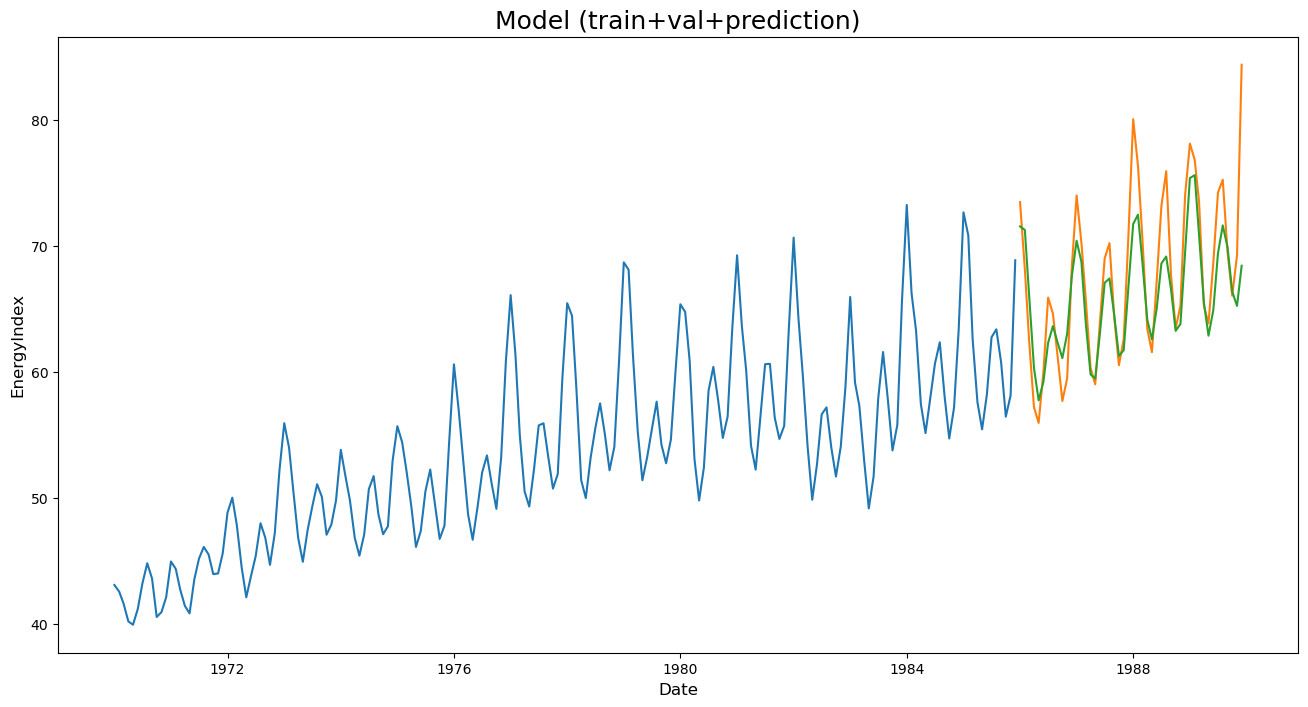

In [77]:
mape = mean_absolute_percentage_error(data[training_data_len:],predictions)
rmse = mean_squared_error(data[training_data_len:],predictions)
mae = mean_absolute_error(data[training_data_len:],predictions)

print(f'MAPE:{mape[0]}')
print(f'RMSE:{rmse}')
print(f'MAE:{mae}')

plt.figure(figsize=(16,8))
plt.title('Model (train+val+prediction)',fontsize=18)
plt.xlabel('Date',fontsize=12)
plt.ylabel('EnergyIndex',fontsize=12)
plt.plot(train['EnergyIndex'])
plt.plot(valid_df[['EnergyIndex','Predictions']])
plt.show()

# Kesimpulan

Penggunaan model dengan ARIMA lebih baik dibandingkan dengan menggunakan teknik deeplearning dapat dilihat dari rmse, mae, dan mape yang lebih kecil.<br>
<br>

>**LSTM**
>* MAPE:3.667495539086408
>* RMSE:13.60631431350251
>* MAE:2.5979473889668783

>**SARIMA**
>* MAPE:1.7790918762514853
>* RMSE:1.844518794972713
>* MAE:1.0346672425655064